In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
file_path = 'gdrive/My Drive/ColabNotebooks/Seahorse/' 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import scipy.signal
from sys import getsizeof
import matplotlib.pyplot as plt
import re 

In [0]:
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, clone_model
from keras.utils import np_utils
from keras.utils import to_categorical

## try CNN model using 2D data (oscillator/price/macd plots)

In [0]:
def normalize_data(data): 
    for i in range(data.shape[0]): 
        row = data.iloc[i, :] 
        data.iloc[i, :] = (row - min(row))/(max(row) - min(row)) 
    return data

In [0]:
class StockData_normalized():
    def __init__(self, file_path):
        '''
        input parameter "file_path" refers to the data file that contains all of the cleaned data, including oscillator, price, macd, return, symbol and label. 
        '''
        data = pd.read_csv(file_path, header=0, index_col=0) 
        print("read_csv done")
        
        pos_data = data[data['label'] == 1]
        neg_data = data[data['label'] == 0]
        
        sample_size = 15000
        pos_data = pos_data.sample(int(sample_size/2))
        neg_data = neg_data.sample(int(sample_size/2))
        data = pd.concat([pos_data, neg_data], axis = 0)
        data = data.reset_index(drop = True) 
         
        osc_normalized = normalize_data(data.iloc[:, :41])
        print("normalize osc done")
        prc_normalized = normalize_data(data.iloc[:, 41:82])
        print("normalize prc done")
        macd_normalized = normalize_data(data.iloc[:, 82:123])
        print("normalize macd done")
        rtn = data['rtn']
        X = pd.concat([osc_normalized, prc_normalized, macd_normalized, rtn], axis=1)
        y = data['label']
        
        X_train_valid_w_rtn, X_test_w_rtn, y_train_valid, y_test = train_test_split(X, y, test_size=0.25) 
        # train_valid set
        self.train_valid_rtn = X_train_valid_w_rtn['rtn']
        self.X_train_valid = X_train_valid_w_rtn.drop(['rtn'], axis = 1)
        self.y_train_valid = y_train_valid
        
        X_train_w_rtn, X_valid_w_rtn, y_train, y_valid = train_test_split(X_train_valid_w_rtn, y_train_valid, test_size=0.25) 
        # training set 
        self.train_rtn = X_train_w_rtn['rtn'] 
        self.X_train = X_train_w_rtn.drop(['rtn'], axis = 1)
        self.y_train = y_train
        # validation set
        self.valid_rtn = X_valid_w_rtn['rtn']
        self.X_valid = X_valid_w_rtn.drop(['rtn'], axis = 1) 
        self.y_valid = y_valid
        # test set 
        self.test_rtn = X_test_w_rtn['rtn']
        self.X_test = X_test_w_rtn.drop(['rtn'], axis = 1)        
        self.y_test = y_test 

In [0]:
data_normalized = StockData_normalized(file_path + 'D1over5.csv')

read_csv done
normalize osc done
normalize prc done
normalize macd done


In [0]:
def data_to_img(data):
    fig = plt.figure(figsize = (3, 2), frameon=False)
    fig.tight_layout(pad=0)
    plt.plot(range(41), data[:41], 'r')
    plt.plot(range(41), data[41:82], 'g')
    plt.plot(range(41), data[82:], 'b')
    plt.tick_params(axis = 'both', which = 'both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    fig.canvas.draw()
    img_arr = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_arr = img_arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()  
    # print(getsizeof(img_arr))
    return img_arr

In [0]:
# test whether the function works properly
img_arr = data_to_img(data_normalized.X_train.iloc[0, :])
img_arr.shape

(144, 216, 3)

In [0]:
X_train_img = []
for i in range(data_normalized.X_train.shape[0]):
  X_train_img.append(data_to_img(data_normalized.X_train.iloc[i, :123])) 
  if i%1000 == 0:
    print(i, end=' ')
print('\n')
X_train_img = np.array(X_train_img)
X_train_img.shape

0 1000 2000 3000 4000 5000 6000 7000 8000 

(8437, 144, 216, 3)

In [0]:
y_train = to_categorical(data_normalized.y_train)
y_train.shape

(8437, 2)

In [0]:
X_valid_img = []
for i in range(data_normalized.X_valid.shape[0]):
  X_valid_img.append(data_to_img(data_normalized.X_valid.iloc[i, :123])) 
  if i%1000 == 0:
    print(i, end=' ')
print('\n')
X_valid_img = np.array(X_valid_img)
X_valid_img.shape

0 1000 2000 



(2813, 144, 216, 3)

In [0]:
y_valid = to_categorical(data_normalized.y_valid)
y_valid.shape

(2813, 2)

In [0]:
X_test_img = []
for i in range(data_normalized.X_test.shape[0]):
  X_test_img.append(data_to_img(data_normalized.X_test.iloc[i, :123])) 
  if i%1000 == 0:
    print(i, end=' ')
print('\n')
X_test_img = np.array(X_test_img)
X_test_img.shape

0 1000 2000 3000 

(3750, 144, 216, 3)

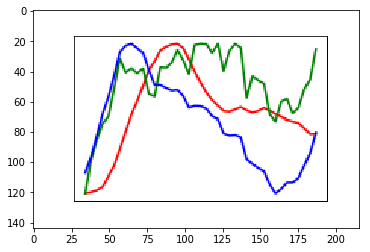

In [0]:
plt.imshow(X_test_img[0,:,:,:])

In [0]:
y_test = to_categorical(data_normalized.y_test)
y_test.shape

(3750, 2)

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(144, 216,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_img, y_train, epochs=20, verbose=1, validation_data=(X_test_img, y_test))

Train on 8437 samples, validate on 3750 samples
Epoch 1/20
8437/8437 [==============================] - 9s 1ms/step - loss: 7.8883 - acc: 0.5018 - val_loss: 8.0633 - val_acc: 0.4997
Epoch 2/20
8437/8437 [==============================] - 8s 955us/step - loss: 7.8617 - acc: 0.4976 - val_loss: 8.0633 - val_acc: 0.4997
Epoch 3/20
8437/8437 [==============================] - 8s 954us/step - loss: 7.9100 - acc: 0.4932 - val_loss: 8.0633 - val_acc: 0.4997
Epoch 4/20
8437/8437 [==============================] - 8s 955us/step - loss: 7.7706 - acc: 0.5031 - val_loss: 8.0633 - val_acc: 0.4997
Epoch 5/20
8437/8437 [==============================] - 8s 945us/step - loss: 7.8236 - acc: 0.5003 - val_loss: 8.0633 - val_acc: 0.4997
Epoch 6/20
8437/8437 [==============================] - 8s 950us/step - loss: 7.9082 - acc: 0.4958 - val_loss: 8.0633 - val_acc: 0.4997
Epoch 7/20
8437/8437 [==============================] - 8s 961us/step - loss: 7.7632 - acc: 0.5034 - val_loss: 8.0633 - val_acc: 0.4997
Ep

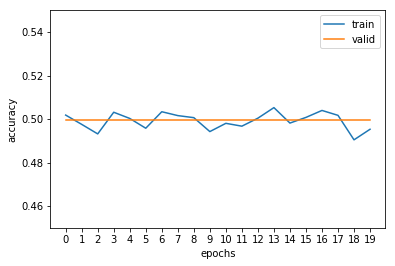

In [0]:
# results using training set and valid set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim(0.45, 0.55)
plt.xticks(range(0, 20))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'valid']);

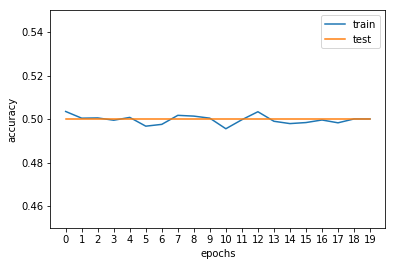

In [0]:
# results using training set and test set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim(0.45, 0.55)
plt.xticks(range(0, 20))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test']);

In [0]:
pred = model.predict(X_valid_img)
pred[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [0]:
tmp = np.transpose(pred, (1, 0))
tmp.shape

(2, 2813)

In [0]:
sum(tmp[0,:])

2813.0

In [0]:
y_test[10,:]

array([0., 1.], dtype=float32)

In [0]:
data_normalized.y_test[10]

1

In [0]:
model.predict(X_valid_img[10:11,:,:,:])

array([[1., 0.]], dtype=float32)